In [12]:
import os
import datetime
import pandas as pd
from sqlalchemy import create_engine
import psycopg2
from dotenv import load_dotenv
import urllib.parse
import matplotlib.pyplot as plt

load_dotenv()
POSTGRES_USERNAME = os.environ.get('JDB_USER')
POSTGRES_PASSWORD = os.environ.get('JDB_PASSWORD')
POSTGRES_ADDRESS = os.environ.get('JDB_HOST')
POSTGRES_PORT = 5432
POSTGRES_DBNAME = os.environ.get('JDB_NAME')
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'.format(username=POSTGRES_USERNAME, password=POSTGRES_PASSWORD, ipaddress=POSTGRES_ADDRESS, port=POSTGRES_PORT, dbname=POSTGRES_DBNAME))
cnx = create_engine(postgres_str)


In [13]:
now = datetime.datetime.now().strftime("%m-%d-%Y")
stays = pd.read_sql_query('select * from stays where use_flag = 1;', cnx)
print("--------------------------------------")
print("BACKGROUND\n")
print("The data consists of {} jail stays for {} unique individuals beginning after January 3, 2022.\n"
      .format(stays['id'].count(), pd.unique(stays['name']).size))
print("Of those, {} stays were completed, {} are still in jail as of {}.\n"
      .format(stays.loc[pd.notnull(stays['end_date'])]['id'].count(),
              stays.loc[pd.isnull(stays['end_date'])]['id'].count(),
              now
             ))
stays = pd.read_sql_query('SELECT * FROM jaildata.stays_summary where not_primary_custodian=0;',
                          cnx)
print("The analysis below involves only the {} completed stays for which Buncombe County is the primary custodian.\n"
     .format(stays['defendant_id'].count()))
mstays = pd.read_sql_query('select * from multi_stay_counts', cnx)
print("As of {}, {} people experienced multiple stays, {} of them 4 or more times, {} of them 3 times, and {} of them twice."
     .format(datetime.date.today().strftime('%Y-%m-%d'),
             mstays['count'].sum(),
             mstays.loc[mstays['nstays'] >= 4]['count'].sum(),
             mstays.loc[mstays['nstays'] == 3]['count'].sum(),
             mstays.loc[mstays['nstays'] == 2]['count'].sum()
            ))

print("--------------------------------------")

--------------------------------------
BACKGROUND

The data consists of 2507 jail stays for 2005 unique individuals beginning after January 3, 2022.

Of those, 2154 stays were completed, 353 are still in jail as of 06-25-2022.

The analysis below involves only the 1940 completed stays for which Buncombe County is the primary custodian.

As of 2022-06-25, 292 people experienced multiple stays, 18 of them 4 or more times, 51 of them 3 times, and 223 of them twice.
--------------------------------------


In [3]:
stays

,defendant_id,name,gender,race,start_date,end_date,days,min_level,max_level,has_violation,violent,dwi,flag,not_primary_custodian,total_secured_bond,has_nobond,last_id
0,8317,"BOATMAN, DAVID SEAN",M,W,2022-01-04,2022-01-04,1.0,1,3,0,0,0,0,0,3000,0,8317
1,8326,"BOWSER, ROBERT EDWIN III",M,W,2022-01-04,2022-01-04,1.0,1,1,0,0,0,0,0,1000,0,8326
2,8477,"INGRAM, JACKSON LAYNE",M,W,2022-01-04,2022-01-04,1.0,1,5,0,0,0,0,0,10000,0,8477
3,8508,"LEEB, TYLER JAMES",M,W,2022-01-04,2022-01-04,1.0,0,0,1,0,0,0,0,2000,0,8508
4,8574,"OLIVA, ALEXANDER",M,W,2022-01-04,2022-01-04,1.0,1,1,0,0,0,0,0,500,0,8574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1935,84445,"GREENE, ANTHONY JOVOHN",M,B,2022-06-23,2022-06-24,2.0,2,2,0,0,0,0,0,1000,0,84886
1936,79100,"HOOKER, TERRY PHILIP",M,W,2022-06-11,2022-06-24,14.0,0,0,0,0,0,1,0,0,1,84922
1937,79100,"HOOKER, TERRY PHILIP",M,W,2022-06-11,2022-06-24,14.0,0,0,0,0,0,1,0,0,1,84922
1938,84591,"PALMER, HOLLY SERENA",F,W,2022-06-23,2022-06-24,2.0,3,3,0,0,0,0,0,2000,0,85033


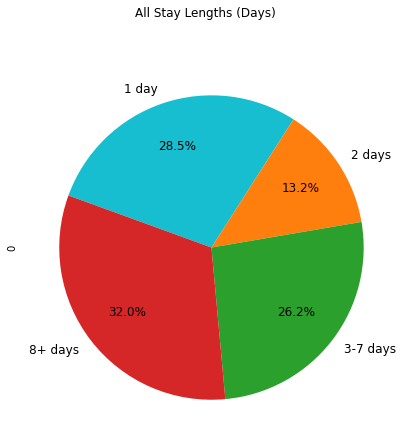

In [4]:
tmp = stays.groupby("days")["days"].count().sort_index()
xdays = pd.concat([tmp.iloc[:2].copy(),pd.DataFrame([[tmp.iloc[2:7].sum()]], index=['3-7']), pd.DataFrame([[tmp.iloc[7:].sum()]], index=['8+'])])
#xdays.columns=['Count']
xdays.index = ['1 day', '2 days', '3-7 days', '8+ days']
colors=['tab:cyan', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
       'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:blue', ]
xfig = xdays.plot.pie(subplots=True, title="All Stay Lengths (Days)", counterclock=False, 
                  legend=False, autopct='%1.1f%%', pctdistance=.7, figsize=[7,7],
                  startangle=160, colors=colors, fontsize=12)


In [5]:
tmp = stays.groupby("days")["days"].count().sort_index()
days = pd.concat([tmp.iloc[:7].copy(), pd.DataFrame([[tmp.iloc[7:].sum()]], index=['8+'])])
days.columns=['Count']
days

,Count
1.0,553
2.0,257
3.0,162
4.0,109
5.0,96
6.0,88
7.0,54
8+,621


In [6]:
tmp = stays.loc[stays["race"] == "B"].groupby("days")["days"].count().sort_index()
daysB = pd.concat([tmp.iloc[:7].copy(), pd.DataFrame([[tmp.iloc[7:].sum()]], index=['8+'])])
tmp = stays.loc[stays["race"] == "W"].groupby("days")["days"].count().sort_index()
daysW = pd.concat([tmp.iloc[:7].copy(), pd.DataFrame([[tmp.iloc[7:].sum()]], index=['8+'])])

daysRace = pd.concat([daysW, daysB], axis=1)
daysRace.columns = ['White', 'Black']
daysRace.index.name = 'Days'
daysRace['Black'] = 100 * daysRace['Black']/daysRace['Black'].sum()
daysRace['White'] = 100 * daysRace['White']/daysRace['White'].sum()
daysRace['Diff']  = daysRace['White'] - daysRace['Black']
daysRace

,White,Black,Diff
Days,,,
1.0,29.061489,26.685393,2.376095
2.0,13.462783,12.078652,1.384131
3.0,7.896440,10.393258,-2.496818
4.0,5.760518,5.337079,0.423439
5.0,5.177994,3.651685,1.526308
6.0,4.854369,2.808989,2.045380
7.0,2.653722,3.370787,-0.717065
8+,31.132686,35.674157,-4.541471


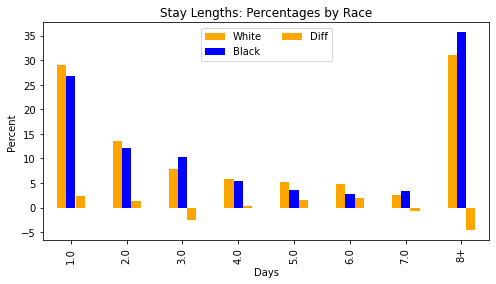

In [7]:
daysRace.plot.bar(title="Stay Lengths: Percentages by Race", figsize=[8,4], color=['Orange','Blue'])
plt.ylabel('Percent')
plt.legend()
plt.legend(bbox_to_anchor=[0.5, 0.9], loc='center', ncol=2)
plt.show()

In [8]:
tmp = stays.loc[stays["gender"] == "M"].groupby("days")["days"].count().sort_index()
daysM = pd.concat([tmp.iloc[:7].copy(), pd.DataFrame([[tmp.iloc[7:].sum()]], index=['8+'])])
tmp = stays.loc[stays["gender"] == "F"].groupby("days")["days"].count().sort_index()
daysF = pd.concat([tmp.iloc[:7].copy(), pd.DataFrame([[tmp.iloc[7:].sum()]], index=['8+'])])

daysGender = pd.concat([daysM, daysF], axis=1)
daysGender.columns = ['Male', 'Female']
daysGender.index.name = 'Days'
daysGender['Male'] = 100 * daysGender['Male']/daysGender['Male'].sum()
daysGender['Female'] = 100 * daysGender['Female']/daysGender['Female'].sum()
daysGender

,Male,Female
Days,,
1.0,28.363384,28.915663
2.0,12.829404,14.457831
3.0,8.183079,8.835341
4.0,5.686546,5.421687
5.0,4.299584,6.827309
6.0,4.854369,3.614458
7.0,2.357836,4.016064
8+,33.425798,27.911647


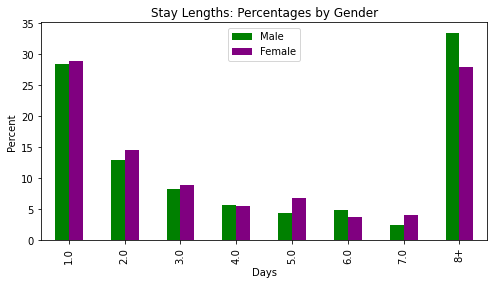

In [9]:
daysGender.plot.bar(title="Stay Lengths: Percentages by Gender", figsize=[8,4], color=['Green','Purple'])
plt.ylabel('Percent')
plt.legend(bbox_to_anchor=[0.5, 0.9], loc='center')
plt.show()

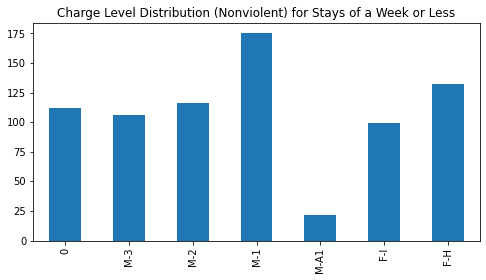

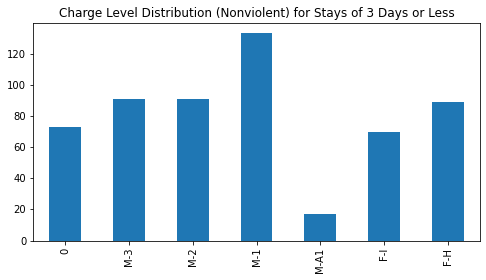

In [14]:
weekStays = stays[(stays["max_level"]<7) & (stays["days"] < 8) & (stays["violent"]==0) & (stays["has_violation"]==0)]
weekStays = weekStays.sort_values(by=["max_level"], ascending=True)
weekStays = weekStays.groupby("max_level", as_index=True)["max_level"].count().sort_index()
weekStays.index.name = 'Level'
weekStays.columns = ['Count']
weekStays.index = ['0', 'M-3', 'M-2', 'M-1', 'M-A1', 'F-I', 'F-H']

days3Stays = stays[(stays["max_level"]<7) & (stays["days"] < 4) & (stays["violent"]==0) & (stays["has_violation"]==0)]
days3Stays = days3Stays.sort_values(by=["max_level"], ascending=True)
days3Stays = days3Stays.groupby("max_level", as_index=True)["max_level"].count().sort_index()
days3Stays.index.name = 'Level'
days3Stays.columns = ['Count']
days3Stays.index = ['0', 'M-3', 'M-2', 'M-1', 'M-A1', 'F-I', 'F-H']

weekStays.plot.bar(title='Charge Level Distribution (Nonviolent) for Stays of a Week or Less', figsize=[8,4])
plt.show()
days3Stays.plot.bar(title='Charge Level Distribution (Nonviolent) for Stays of 3 Days or Less', figsize=[8,4])
plt.show()

(array([161.,  20.,  20.,  20.,   4., 101.,   1.,   0.,   1.,   0., 134.,
          1.,   1.,   0.,   0.,  20.,   0.,   0.,   0.,   0.,  72.,   0.,
          1.,   0.,   0.,  18.,   0.,   0.,   0.,   0.,  47.,   0.,   0.,
          0.,   0.,   7.,   0.,   1.,   0.,   0.,  21.,   0.,   0.,   1.,
          0.,   3.,   0.,   0.,   0.,  77.]),
 array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,
         900., 1000., 1100., 1200., 1300., 1400., 1500., 1600., 1700.,
        1800., 1900., 2000., 2100., 2200., 2300., 2400., 2500., 2600.,
        2700., 2800., 2900., 3000., 3100., 3200., 3300., 3400., 3500.,
        3600., 3700., 3800., 3900., 4000., 4100., 4200., 4300., 4400.,
        4500., 4600., 4700., 4800., 4900., 5000.]),
 <BarContainer object of 50 artists>)

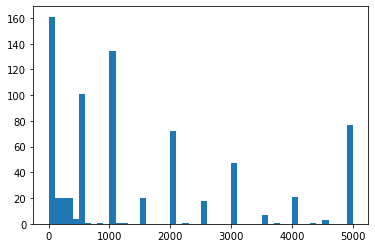

In [11]:
weekBonds = stays[(stays['days']<8) & (stays['has_nobond']==0) & (stays['has_violation'] ==0)]
plt.hist(weekBonds['total_secured_bond'], range=(0,5000), bins=50)

# Map of levels:

Level|Misdemeanor Description| |Level|Felony Description| |Level |Misc Description|
:-----|:-----------| |:-----|:-----------| |:---------|:-----------|
1|Class 3| |5|Class I| |-1|NONE|
2|Class 2| |6|Class H| |-2|5305|
3|Class 1| |7|Class G| |-3|??|
4|Class A1| |8|Class F| | |
|| |9|Class E| | | |
|| |10|Class D| | | |
|| |11|Class C| | | |
|| |12|Class B2| | | |
|| |13|Class B1| | | |
|| |14|Class A| | | |
